# Regression Model with Tensorflow Decision Forests (local)

In [1]:
!pip install --user --quiet pandas-gbq tensorflow tensorflow_decision_forests tensorflow-addons
import logging
logging.getLogger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data with BigQuery

In [4]:
df_csv = pd.read_csv('gs://sandbox-michael-menzel-data-europe-west4/advertising-regression-data/advertising_with_header.csv')
df_csv.to_gbq('example_dataset.advertising_regression', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6636.56it/s]


In [5]:
%%bigquery df
SELECT * FROM example_dataset.advertising_regression

Downloading: 100%|██████████| 200/200 [00:00<00:00, 224.65rows/s]


In [6]:
df

,TV,Radio,Newspaper,Sales
0,7.3,28.1,41.4,5.5
1,18.8,21.7,50.4,7.0
2,17.9,37.6,21.6,8.0
3,25.1,25.7,43.3,8.5
4,25.6,39.0,9.3,9.5
...,...,...,...,...
195,255.4,26.9,5.5,19.8
196,273.7,28.9,59.7,20.8
197,241.7,38.0,23.2,21.8
198,210.8,49.6,37.7,23.8


In [7]:
from google.cloud import bigquery

query_job = bigquery.Client().query('select * from example_dataset.advertising_regression')
df = query_job.result().to_dataframe()
df

,TV,Radio,Newspaper,Sales
0,7.3,28.1,41.4,5.5
1,18.8,21.7,50.4,7.0
2,17.9,37.6,21.6,8.0
3,25.1,25.7,43.3,8.5
4,25.6,39.0,9.3,9.5
...,...,...,...,...
195,255.4,26.9,5.5,19.8
196,273.7,28.9,59.7,20.8
197,241.7,38.0,23.2,21.8
198,210.8,49.6,37.7,23.8


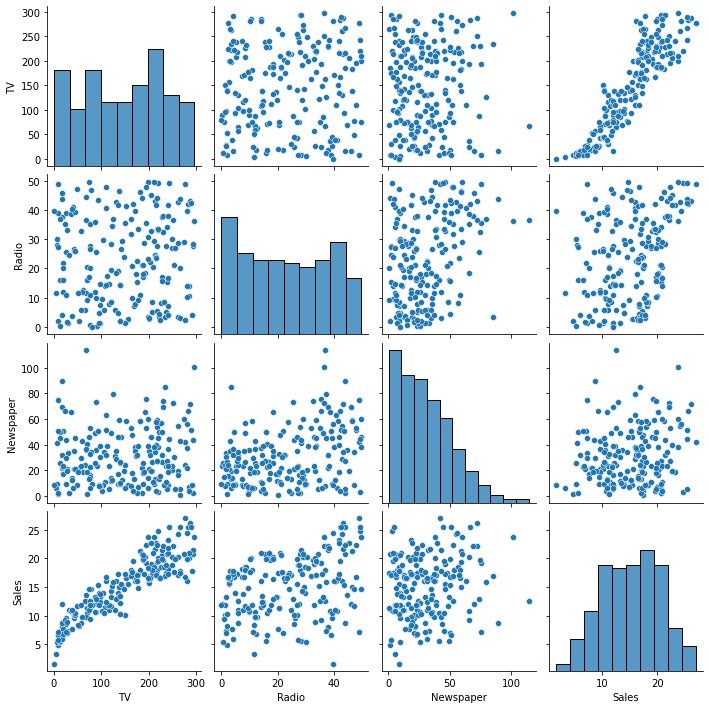

In [8]:
sns.pairplot(df)

## Define Datasets & Train Model

In [7]:
TARGET = 'Sales'

test_split = int(len(df[TARGET]) * 0.1)
print(f'Splitting dataset into {len(df[TARGET]) - test_split} items for training and {test_split} items for test.')

dataset_train = (tfdf.keras.pd_dataframe_to_tf_dataset(df[test_split:], label=TARGET, task=tfdf.keras.Task.REGRESSION)
                 .cache())
dataset_test = (tfdf.keras.pd_dataframe_to_tf_dataset(df[:test_split], label=TARGET, task=tfdf.keras.Task.REGRESSION)
                .cache())


Splitting dataset into 180 items for training and 20 items for test.


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [16]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=[rmse, 'mse', 'mae', 'mape', tfa.metrics.RSquare(y_shape=(1,))])
history = model.fit(dataset_train)

3/3 [==============================] - 0s 2ms/step


In [17]:
evaluation = model.evaluate(dataset_test, return_dict=True)

1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - rmse: 1.7097 - mse: 2.9231 - mae: 1.5024 - mape: 13.8479 - r_square: 0.5947


In [12]:
test_labels = list(dataset_test.map(lambda x, y: y))
test_x = dataset_test

test_pred = tf.cast(tf.squeeze(model.predict(test_x.unbatch().batch(1))), tf.float64)
test_truth = tf.squeeze(test_labels)

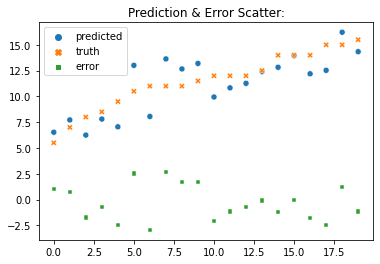

In [14]:
df_plot = pd.DataFrame({'predicted': test_pred, 'truth': test_truth})
df_plot['error'] = tf.subtract(test_pred, test_truth)

figure, ax = plt.subplots()
sns.scatterplot(data=df_plot.sort_values('truth').reset_index(drop=True), ax=ax)
plt.title(f'Prediction & Error Scatter:')
plt.show()